In [3]:
## Importing the necessary libraries ##
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow as tf
from PIL import Image ## For checking image consistencies ##
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
## Mounting Drive ##
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## From the Drive , Zip file is to be extracted and unzipped ##
zip_path = '/content/drive/MyDrive/Tumour-20250805T040601Z-1-001.zip'

import zipfile

## Destination folder for the extracted files ##
extract_to = '/content/drive/MyDrive/TumourData'

## Unzip the files ##
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipped successfully")



Unzipped successfully


In [6]:
## Defining the folder paths ##

train_data_path = '/content/drive/MyDrive/TumourData/Tumour/train'
test_data_path = '/content/drive/MyDrive/TumourData/Tumour/test'
validate_data_path = '/content/drive/MyDrive/TumourData/Tumour/valid'

# **Understanding the DataSet**


 Dataset: Train Set
Number of tumor categories: 4
Sample Images count per category:
no_tumor: 335 images
meningioma: 358 images
pituitary: 438 images
glioma: 564 images


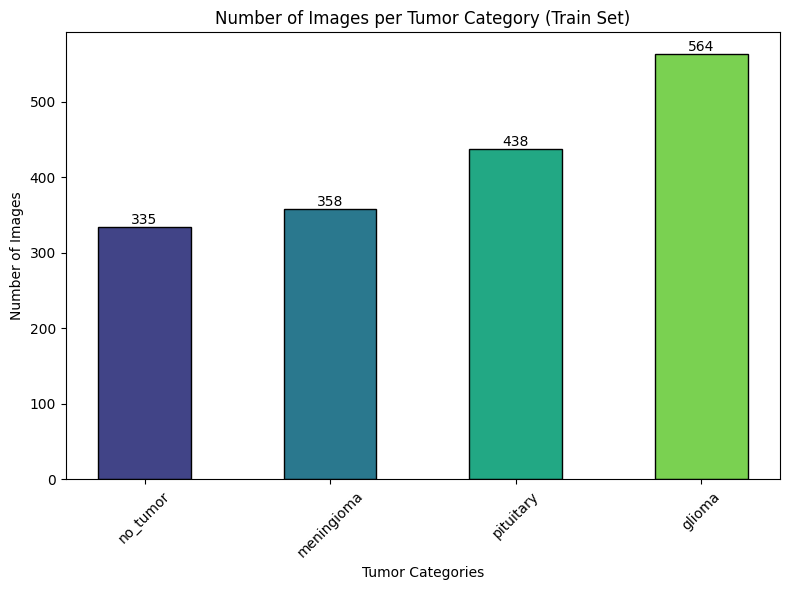


 Dataset: Test Set
Number of tumor categories: 4
Sample Images count per category:
no_tumor: 49 images
meningioma: 63 images
pituitary: 54 images
glioma: 80 images


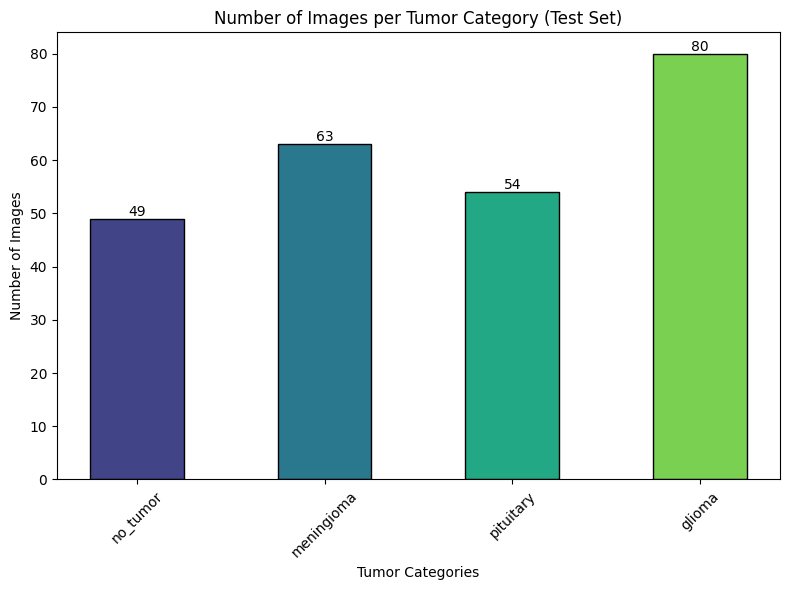


 Dataset: Validation Set
Number of tumor categories: 4
Sample Images count per category:
no_tumor: 99 images
glioma: 161 images
pituitary: 118 images
meningioma: 124 images


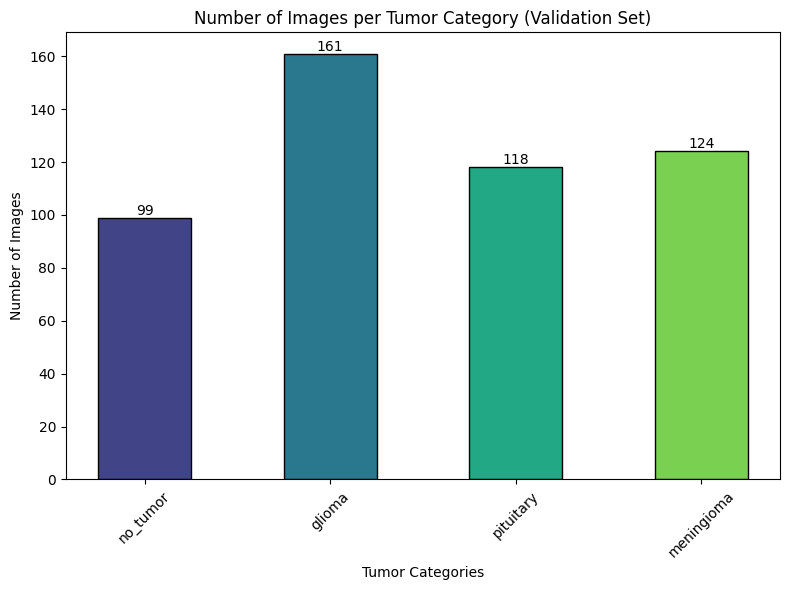

In [ ]:
## Checking the number of Tumor categories and the number of sample images in each category ##

def countCategory_plotImages(data_path, dataset_name):
  if not os.path.exists(data_path):
    print(f"Error: The directory '{data_path}' was not found.")
  else:
    tumor_categories = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    print(f"\n Dataset: {dataset_name}")
    print(f"Number of tumor categories: {len(tumor_categories)}")
    print("Sample Images count per category:")

    image_counts = {} ## Initializing an empty dictionary to store the image counts ##

    for category in tumor_categories:
        category_path = os.path.join(data_path, category)
        num_images = len([f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))])
        print(f"{category}: {num_images} images")
        image_counts[category] = num_images

    ## Visualising the categories ##
    tumor_categories = list(image_counts.keys())
    num_images = list(image_counts.values())
    colors = sns.color_palette('viridis', len(tumor_categories))
    plt.figure(figsize=(8,6))
    bars = plt.bar(tumor_categories, num_images, color=colors, edgecolor='black',width=0.5) ## Plotting the bars ##
    ## Adding annotation to the bars ##
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')
    plt.xlabel('Tumor Categories')
    plt.ylabel('Number of Images')
    plt.title(f'Number of Images per Tumor Category ({dataset_name})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

countCategory_plotImages(train_data_path, "Train Set")
countCategory_plotImages(test_data_path, "Test Set")
countCategory_plotImages(validate_data_path, "Validation Set")

In [ ]:
## As seen in the plot , class imbalance is there . But since it is a image classification , need not handle it ##

**Checking Image resolution consistency**

In [ ]:
resolutions = []

for category in os.listdir(train_data_path):
    category_path = os.path.join(train_data_path, category)
    if os.path.isdir(category_path):
        for file in os.listdir(category_path):
          file_path = os.path.join(category_path, file)
          try:
            with Image.open(file_path) as img:
              resolutions.append(img.size)
          except:
            pass ## Skipping unreadable image files ##
            continue

## Analyzing resolution distribution ##
resolution_counts = Counter(resolutions)
print(resolution_counts)
print("Image resolution frequencies:")
for res, count in resolution_counts.items():
    print(f"Resolution{res}: {count} images")
if len(resolution_counts) == 1:
  print("All images have the same resolution.")
else:
  print("Images have different resolutions.")

Counter({(640, 640): 1695})
Image resolution frequencies:
Resolution(640, 640): 1695 images
All images have the same resolution.


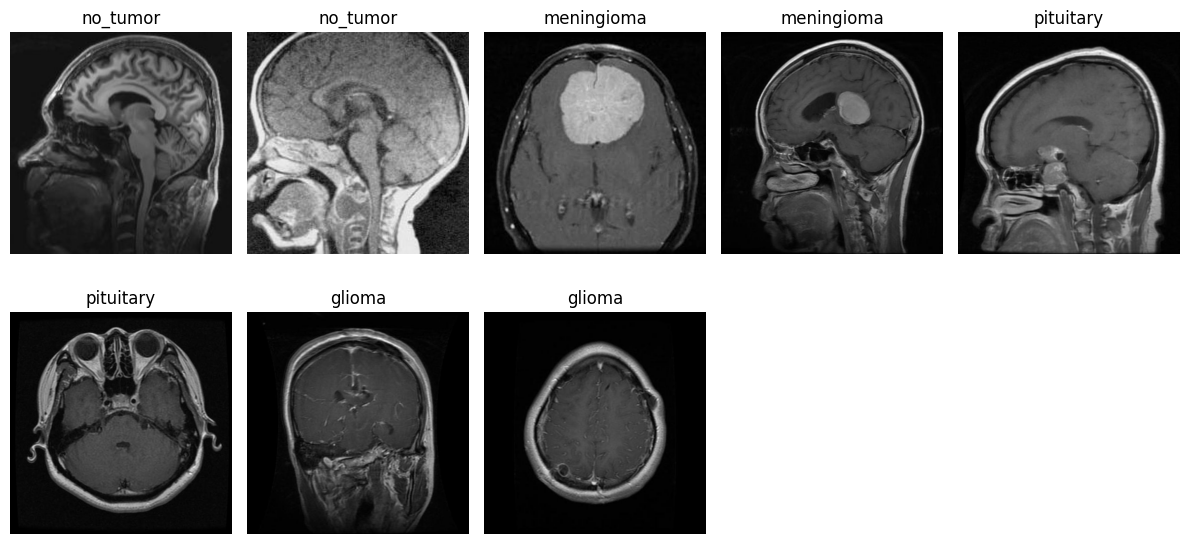

In [ ]:
## Exploring Image types by randomly picking images from different categories and checking them visually ##


import random

folder = train_data_path
sample_images = []  # Store tuples of (category, image_path)

## Collecting random samples from each category ##
for cat in os.listdir(folder):
    cat_path = os.path.join(folder, cat)
    if os.path.isdir(cat_path):
        images = [f for f in os.listdir(cat_path) if f.endswith(('.jpg', '.png'))]
        selected = random.sample(images, min(2, len(images)))
        for img_name in selected:
            sample_images.append((cat, os.path.join(cat_path, img_name)))

## Limiting the number of images to max ##
sample_images = sample_images[:10]

## Plotting grid ##
plt.figure(figsize=(12, 6))
for i, (cat, img_path) in enumerate(sample_images):
    plt.subplot(2, 5, i + 1)
    img = Image.open(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(cat)
    plt.axis('off')

plt.tight_layout()
plt.show()


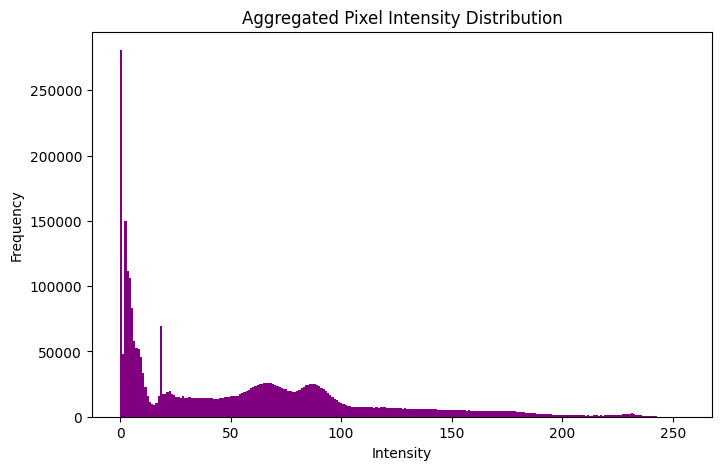

In [ ]:
## Understanding pixel intensity ##

all_pixels = []

## Combining pixels from all
for cat, img_path in sample_images:
    img = Image.open(img_path).convert('L')  # Ensure grayscale
    pixels = np.array(img).flatten()
    all_pixels.extend(pixels)

## Plot combined histogram
plt.figure(figsize=(8, 5))
plt.hist(all_pixels, bins=256, color='purple')
plt.title('Aggregated Pixel Intensity Distribution')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()


1.The histogram shows a dominant concentration of dark pixels, with most
values clustered near intensity 0–100, especially at 0.

2.This indicates the images have low brightness overall .

3.Higher intensities are rare.

4.This indicates that contrast enhancement techniques or normalization might be needed before model training.



In [ ]:
## Understanding the statistical values and attributes of the images ##

base_paths = {
    "Train": train_data_path,
    "Test": test_data_path,
    "Validation": validate_data_path
    }

## Initializing stats outside all loops for capturing all categories across Train,Test,Validation ##
stats = []

## Looping through each dataset (Train, Test, Validation) ##
for set_name, path in base_paths.items():
    if not os.path.exists(path):
        print(f"Path not found: {path}")
        continue
    ## Looping through each tumor category within the dataset ##
    for category in os.listdir(path):
        category_path = os.path.join(path, category)
        if not os.path.isdir(category_path):
            continue

        ## Initialising empty list for dumping data ##
        img_sizes = []
        pixel_means = []
        pixel_stds = []
        color_modes = set()

        ## Looping over each image file in the category folder ##
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                ## Opening image and converting to NumPy array ##
                img = Image.open(img_path).convert('RGB')
                img_array = np.array(img)

                img_sizes.append(img.size)              # Width, Height
                pixel_means.append(np.mean(img_array))  # Overall brightness
                pixel_stds.append(np.std(img_array))    # Intesity variation
                color_modes.add(img.mode)               # RGB
            except:
                continue
        ## Saving the stats for current category into a dictionary ##
        stats.append({
            'Dataset': set_name,
            'Category': category,
            'Image Count': len(img_sizes),
            'Resolution(s)': list(set(img_sizes)),
            'Color Mode(s)': list(color_modes),
            'Mean Intensity': round(np.mean(pixel_means), 2) if pixel_means else 'N/A',
            'Std Dev Intensity': round(np.mean(pixel_stds), 2) if pixel_stds else 'N/A'
        })

## Converting to DataFrame for better visibility ##
df_stats = pd.DataFrame(stats)
pd.set_option('display.max_colwidth', None)

In [ ]:
df_stats

,Dataset,Category,Image Count,Resolution(s),Color Mode(s),Mean Intensity,Std Dev Intensity
0,Train,no_tumor,335,"[(640, 640)]",[RGB],59.39,56.16
1,Train,meningioma,358,"[(640, 640)]",[RGB],46.17,48.52
2,Train,pituitary,438,"[(640, 640)]",[RGB],50.45,41.55
3,Train,glioma,564,"[(640, 640)]",[RGB],27.84,36.26
4,Test,no_tumor,49,"[(640, 640)]",[RGB],63.50,57.25
5,Test,meningioma,63,"[(640, 640)]",[RGB],45.98,49.35
6,Test,pituitary,54,"[(640, 640)]",[RGB],51.23,40.79
7,Test,glioma,80,"[(640, 640)]",[RGB],28.11,35.87
8,Validation,no_tumor,99,"[(640, 640)]",[RGB],59.79,55.88
9,Validation,glioma,161,"[(640, 640)]",[RGB],27.40,35.84


**Observations:**

1.Image size is consistent — Every picture is 640×640

2.All images are in RGB mode, but they look more like grayscale stored in color format

3."No tumor" images are much brighter than the ones with tumors.

4."Glioma" images are the darkest

5.Differences in brightness (intensity) across categories

6.Normalisation of images is required

# **Data Preprocessing** **& Data Augmentation**

In [ ]:
## We are going to use ImageDataGenerator which will ##
## load images in batches ,preprocess and augument during training/testing/validation ##
## It helps keep memory usage low since all images are not loaded into RAM at once ##

In [7]:
## Defining the class order explicitly for all the generators ##
class_order = ['glioma','meningioma','no_tumor','pituitary']

## Creating the training generator with augumentation and preprocessing ##
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values betweent [0, 1]
    rotation_range=20,      # Randomly rotate images upto 20 desgrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Shift images vertically by up to 20% of the height
    zoom_range=0.2,         # zoom variation of ±20%.Image can shrink to 80% or expand to 120%
    shear_range=0.2,        # Apply shear transformations like slant or skew an image
    horizontal_flip=True,   # Flip images horizontally (like mirror reflection)
    vertical_flip=False,    # Dont flip vertically - to preserve natural orientation especially for medical scans
    fill_mode='nearest'     # Fill in pixels that are introduced during transformations using the nearest pixel values
)

# Validation and test generators (Only normalising , no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
## Loading the images from folders and applying the generators ##

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),  # Image is resized from 640 to 224 pixels
    batch_size=32,           # Standard batch size
    class_mode='categorical', # Multiclass classification
    classes=class_order
)
validate_generator = val_datagen.flow_from_directory(
    validate_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_order
)
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_order,
    shuffle=False
)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [9]:
print("Train Generator Class Indices:", train_generator.class_indices)
print("Validation Generator Class Indices:", validate_generator.class_indices)

Train Generator Class Indices: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Validation Generator Class Indices: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


# **Model Building**

# **1.Custom CNN Model**

In [11]:
## Initialising to capture different model parameters ##
model_comparison=[]

In [46]:
model = Sequential()

## Convolutional Block 1 ##
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3))) # Learning basic features
#model.add(BatchNormalization())                          # Normalize feature maps across the batch
model.add(MaxPooling2D(pool_size=(2, 2)))                # Downsampling the image
#model.add(Dropout(0.2))                                  # Light dropout for early layer - Reduces overfitting

## Convolutional Block 2 ##
model.add(Conv2D(64, (3, 3), padding='same', activation='relu')) # Learning deeper features
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))                                  # Slightly higher dropout

## Convolutional Block 3 ##
model.add(Conv2D(128, (3, 3), padding='same', activation='relu')) # Learning High-level patterns
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))                                  # Stronger regularization in deeper layers

## Flatten and Fully Connected Layers ##
model.add(Flatten())                                     # Convert to 1D for dense layers
model.add(Dense(128, activation='relu'))                 # Learning non-spatial features
#model.add(BatchNormalization())                          # Normalize before final activation
#model.add(Dropout(0.5))                                  # High dropout to prevent overfitting
model.add(Dense(4, activation='softmax'))                # Output probabilities for 4 classes



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
## Compiling the model and printing the evaluation metrics ##

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

In [48]:
## Summary data ##
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
## Number of times the model will run the entire training set ##
epochs = 10
batch_size = 32

## Training the model ##
history = model.fit(
    train_generator,                                        # Input data from training folder
    steps_per_epoch=train_generator.samples // batch_size,  # Number of batches per training epoch
    epochs=epochs,                                          # Total training cycles
    validation_data=validate_generator,                   # Using validation data to track performance
    validation_steps=validate_generator.samples // batch_size  # Batches used per validation epoch
)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 44s 726ms/step - accuracy: 0.3867 - loss: 1.5837 - precision: 0.4358 - recall: 0.1074 - val_accuracy: 0.5833 - val_loss: 0.9764 - val_precision: 0.6581 - val_recall: 0.4250
Epoch 2/10
 1/52 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6250 - loss: 1.0702 - precision: 0.5789 - recall: 0.3438

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6250 - loss: 1.0702 - precision: 0.5789 - recall: 0.3438 - val_accuracy: 0.5708 - val_loss: 0.9848 - val_precision: 0.6667 - val_recall: 0.4500
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 70s 626ms/step - accuracy: 0.6256 - loss: 0.9749 - precision: 0.7411 - recall: 0.4171 - val_accuracy: 0.6604 - val_loss: 0.8253 - val_precision: 0.7161 - val_recall: 0.5833
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6250 - loss: 0.7947 - precision: 0.7826 - recall: 0.5625 - val_accuracy: 0.6604 - val_loss: 0.8439 - val_precision: 0.7273 - val_recall: 0.5667
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 619ms/step - accuracy: 0.6158 - loss: 0.9028 - precision: 0.7053 - recall: 0.5062 - val_accuracy: 0.6979 - val_loss: 0.7738 - val_precision: 0.7857 - val_recall: 0.5958
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7812 - loss: 0.5669 - precision: 0.9583 - recall: 0.7188 - val_accuracy: 0.6938 - val_loss: 0.8051 - val_p

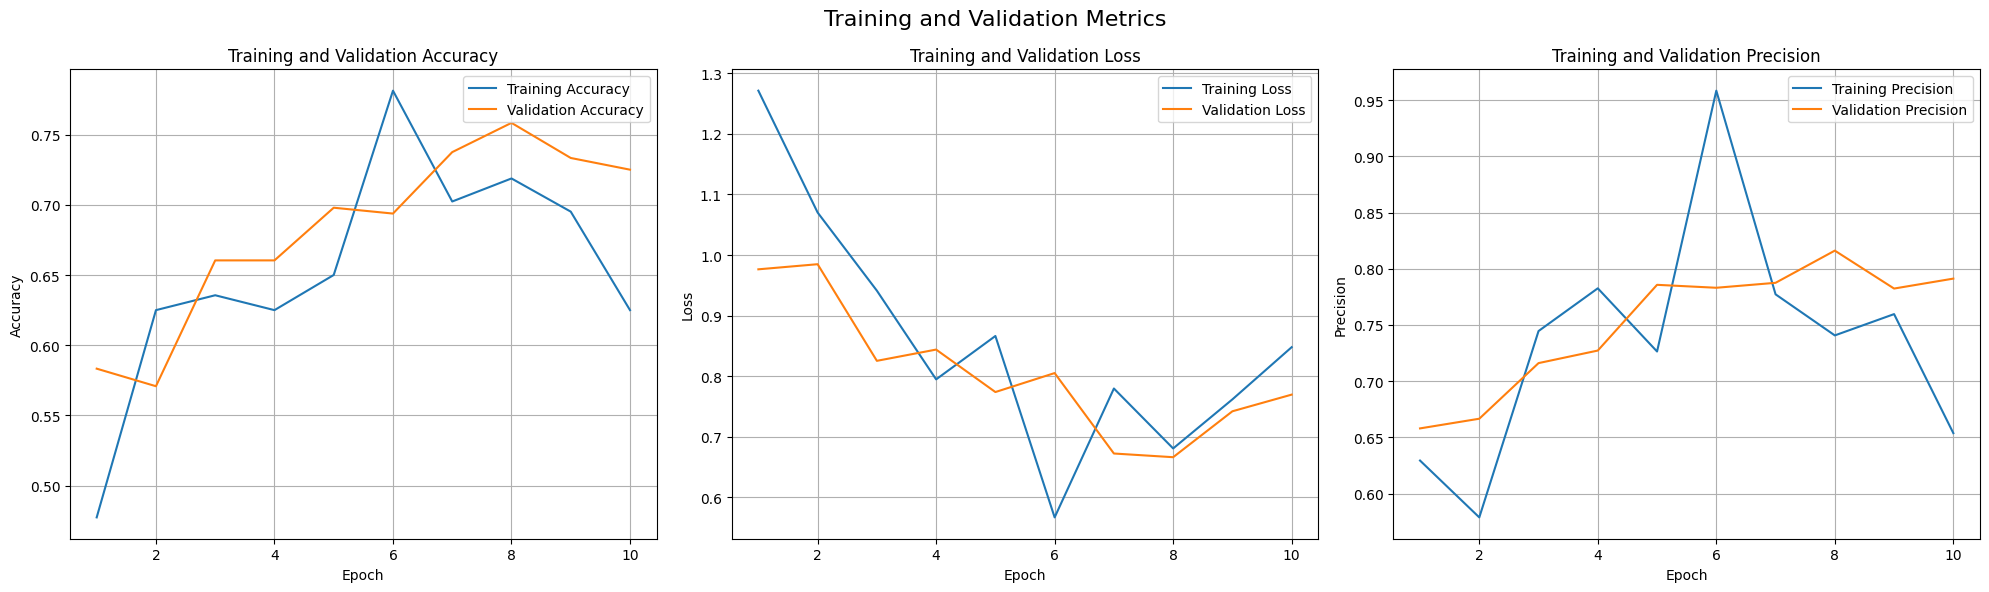

In [50]:
## Plotting the metrics ##

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
epochs_range = range(1, len(history.history['accuracy']) + 1)

## Creating the subplots ##
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Training and Validation Metrics', fontsize=16)

## Plotting Accuracy ##
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()
ax1.grid(True)

## Plotting Loss ##
ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()
ax2.grid(True)

## Plotting Precision ##
ax3.plot(epochs_range, precision, label='Training Precision')
ax3.plot(epochs_range, val_precision, label='Validation Precision')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Precision')
ax3.set_title('Training and Validation Precision')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

In [52]:
## Evaluating the model on test data ##
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_accuracy:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')
print(f'Test loss: {test_loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.6519 - loss: 0.9709 - precision: 0.7275 - recall: 0.5492

Test accuracy: 0.7276
Test precision: 0.7789
Test recall: 0.6301
Test loss: 0.8064


In [15]:
model_comparison.append({
    'Model': 'CustomCNN',
    'Test Accuracy': 0.7276,
    'Test Precision': 0.7789,
    'Test Recall': 0.6301})

In [53]:
## Generating the predictions ##

test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step


Classification Report:
               precision    recall  f1-score   support

      glioma       0.93      0.65      0.76        80
  meningioma       0.68      0.48      0.56        63
    no_tumor       0.71      0.90      0.79        49
   pituitary       0.63      0.98      0.77        54

    accuracy                           0.73       246
   macro avg       0.74      0.75      0.72       246
weighted avg       0.76      0.73      0.72       246



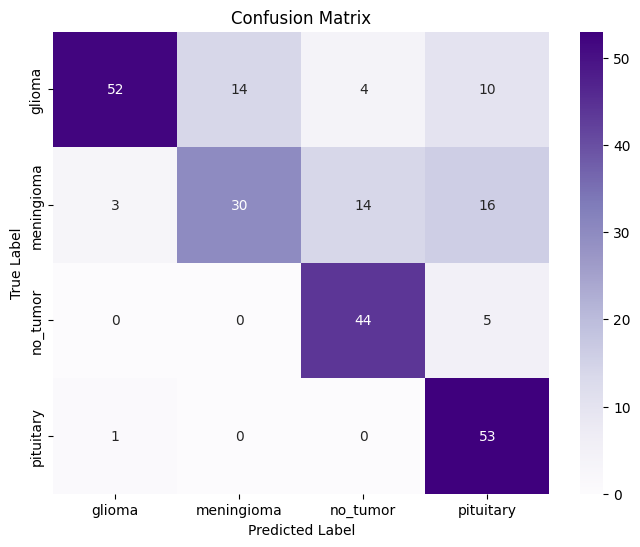

In [54]:
## Getting the class names in the correct order as defined by the generator ##
class_names = list(test_generator.class_indices.keys())

## Generating the classification report ##
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

## Generating and plotting the confusion matrix ##
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Analysis using Transfer Learning Models**

# **1.ResNet50**

In [10]:
from tensorflow.keras.applications import (ResNet50,VGG16,DenseNet121,MobileNet,InceptionV3)

In [12]:
## Loading the pre-trained ResNet50 base model ##
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #Removing the fully connected top layer and replacing with custom layer
base_model.trainable = False #Freezing the layers of base model

## Building the custom layers ##
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x) # Dropout for regularization to prevent overfitting
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(4, activation='softmax')(x) # Output layer with softmax for 4 classes

## Combining the base model with your custom classification layers ##
resNet_model = models.Model(inputs=base_model.input, outputs=predictions)
resNet_model.compile(optimizer=Adam(learning_rate=0.001), # Starting with a small learning rate for fine-tuning
              loss='categorical_crossentropy',metrics=['accuracy',
                                                       tf.keras.metrics.Precision(name='precision'),
                                                       tf.keras.metrics.Recall(name='recall')])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
resNet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,145,668 (92.11 MB)

 Trainable params: 557,956 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
resNet_history = resNet_model.fit(
        train_generator,
        validation_data=validate_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 645s 12s/step - accuracy: 0.3239 - loss: 1.4296 - precision: 0.3413 - recall: 0.0517 - val_accuracy: 0.5139 - val_loss: 1.2282 - val_precision: 0.8387 - val_recall: 0.0518
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 529s 10s/step - accuracy: 0.4513 - loss: 1.2221 - precision: 0.6620 - recall: 0.1338 - val_accuracy: 0.4343 - val_loss: 1.2079 - val_precision: 0.7701 - val_recall: 0.1335
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 505s 10s/step - accuracy: 0.4767 - loss: 1.1822 - precision: 0.7122 - recall: 0.1800 - val_accuracy: 0.4661 - val_loss: 1.1421 - val_precision: 0.6920 - val_recall: 0.3267
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 496s 9s/step - accuracy: 0.4650 - loss: 1.1842 - precision: 0.6145 - recall: 0.2259 - val_accuracy: 0.4841 - val_loss: 1.1567 - val_precision: 0.7222 - val_recall: 0.1813
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 497s 9s/step - accuracy: 0.4915 - loss: 1.1524 - precision: 0.6522 - recall: 0.2171 - val_accuracy: 0.5279 - val_loss: 1.07

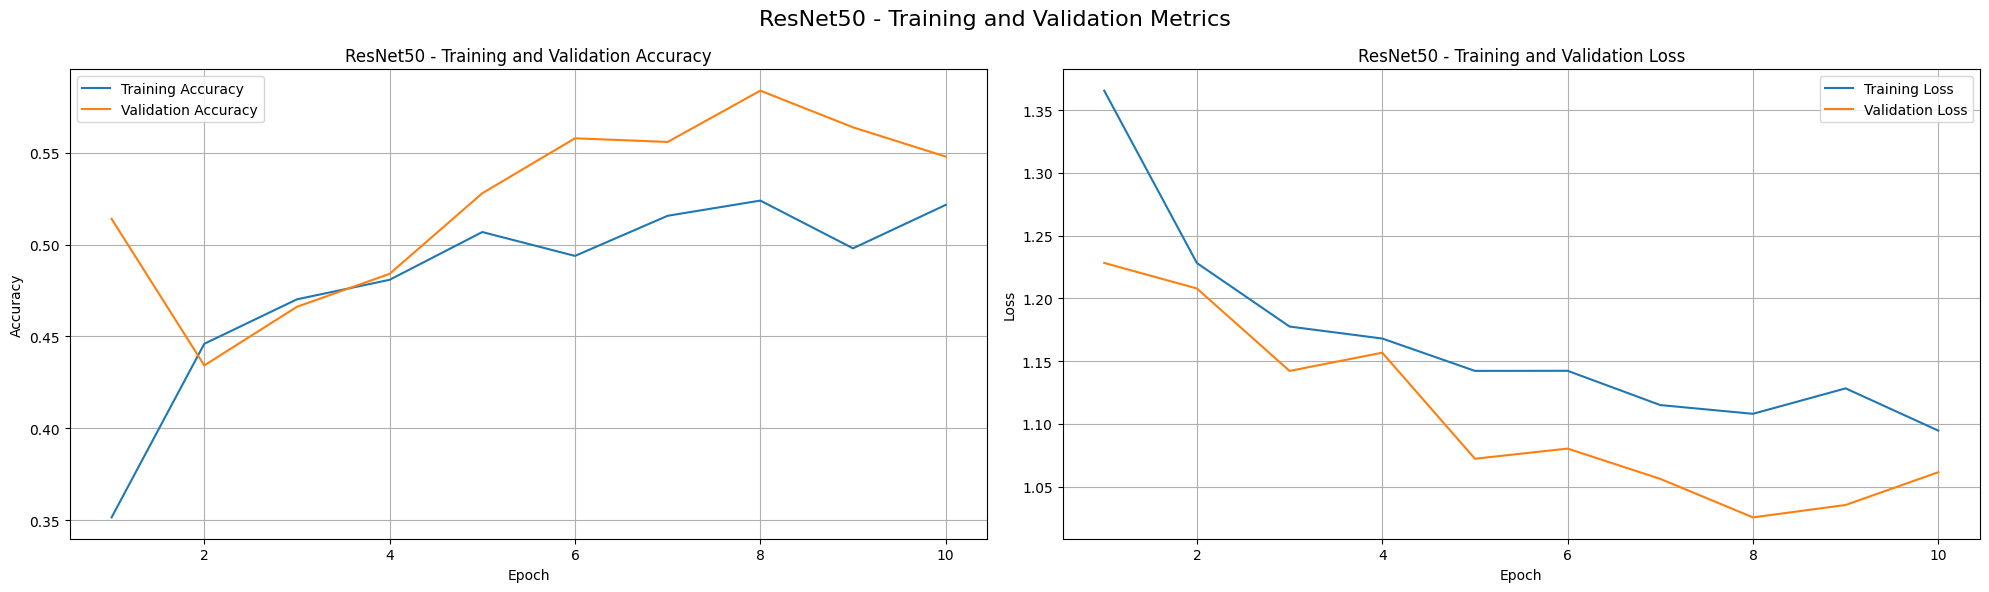

In [16]:
## Plotting the metrics ##

acc = resNet_history.history['accuracy']
val_acc = resNet_history.history['val_accuracy']
loss = resNet_history.history['loss']
val_loss = resNet_history.history['val_loss']
epochs_range = range(1, len(resNet_history.history['accuracy']) + 1)

## Creating the subplots ##
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('ResNet50 - Training and Validation Metrics', fontsize=16)

## Plotting Accuracy ##
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('ResNet50 - Training and Validation Accuracy')
ax1.legend()
ax1.grid(True)

## Plotting Loss ##
ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('ResNet50 - Training and Validation Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [17]:
## Evaluating the model on test data ##
test_loss, test_accuracy, test_precision, test_recall = resNet_model.evaluate(test_generator)
print(f'\nResNet Test accuracy: {test_accuracy:.4f}')
print(f'ResNet Test precision: {test_precision:.4f}')
print(f'ResNet Test recall: {test_recall:.4f}')
print(f'ResNet Test loss: {test_loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 9s/step - accuracy: 0.4962 - loss: 1.1734 - precision: 0.7748 - recall: 0.2689

ResNet Test accuracy: 0.5325
ResNet Test precision: 0.7059
ResNet Test recall: 0.2439
ResNet Test loss: 1.1298


In [18]:
model_comparison.append({
    'Model': 'ResNet50',
    'Test Accuracy': 0.5325,
    'Test Precision': 0.7059,
    'Test Recall': 0.2439})

In [19]:
## Generating the predictions ##
batch_size = 32
test_generator.reset()
predictions = resNet_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step


ResNet50 - Classification Report:
               precision    recall  f1-score   support

      glioma       0.68      0.56      0.62        80
  meningioma       0.71      0.19      0.30        63
    no_tumor       0.55      0.73      0.63        49
   pituitary       0.39      0.70      0.50        54

    accuracy                           0.53       246
   macro avg       0.58      0.55      0.51       246
weighted avg       0.60      0.53      0.51       246



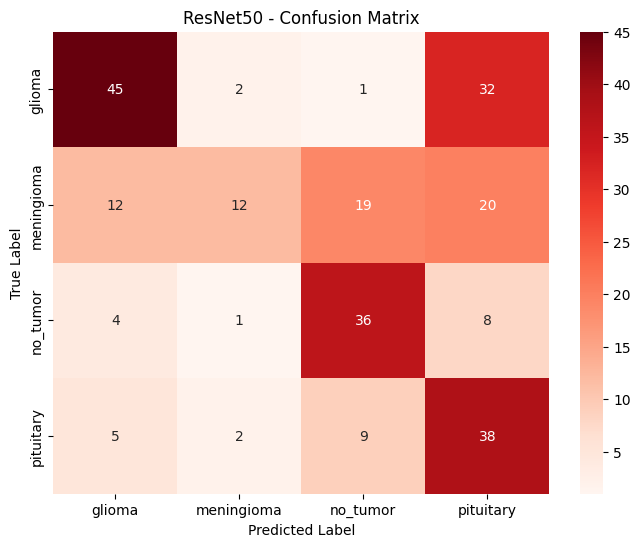

In [20]:
## Getting the class names in the correct order as defined by the generator ##
class_names = list(test_generator.class_indices.keys())

## Generating the classification report ##
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("ResNet50 - Classification Report:\n", report)

## Generating and plotting the confusion matrix ##
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet50 - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **2. VGG16**

In [13]:
## Loading the pre-trained VGG16 base model ##
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #Removing the fully connected top layer and replacing with custom layer
base_model.trainable = False #Freezing the layers of base model

## Building the custom layers ##
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x) # Dropout for regularization to prevent overfitting
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(4, activation='softmax')(x) # Output layer with softmax for 4 classes

## Combining the base model with your custom classification layers ##
VGG16_model = models.Model(inputs=base_model.input, outputs=predictions)
VGG16_model.compile(optimizer=Adam(learning_rate=0.001), # Starting with a small learning rate for fine-tuning
              loss='categorical_crossentropy',metrics=['accuracy',
                                                       tf.keras.metrics.Precision(name='precision'),
                                                       tf.keras.metrics.Recall(name='recall')])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
VGG16_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,879,428 (56.76 MB)

 Trainable params: 164,740 (643.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
VGG16_history = VGG16_model.fit(
        train_generator,
        validation_data=validate_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1222s 23s/step - accuracy: 0.4265 - loss: 1.2652 - precision: 0.6043 - recall: 0.1253 - val_accuracy: 0.6275 - val_loss: 0.8781 - val_precision: 0.6851 - val_recall: 0.4940
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 613ms/step - accuracy: 0.6671 - loss: 0.8333 - precision: 0.7541 - recall: 0.4708 - val_accuracy: 0.7092 - val_loss: 0.6521 - val_precision: 0.7756 - val_recall: 0.6335
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - accuracy: 0.7447 - loss: 0.6490 - precision: 0.8028 - recall: 0.6611 - val_accuracy: 0.7390 - val_loss: 0.6149 - val_precision: 0.7763 - val_recall: 0.6912
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 630ms/step - accuracy: 0.7719 - loss: 0.5666 - precision: 0.8224 - recall: 0.7199 - val_accuracy: 0.7908 - val_loss: 0.5324 - val_precision: 0.8267 - val_recall: 0.7410
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 632ms/step - accuracy: 0.7837 - loss: 0.5442 - precision: 0.8317 - recall: 0.7545 - val_accuracy: 0.7689 - val_los

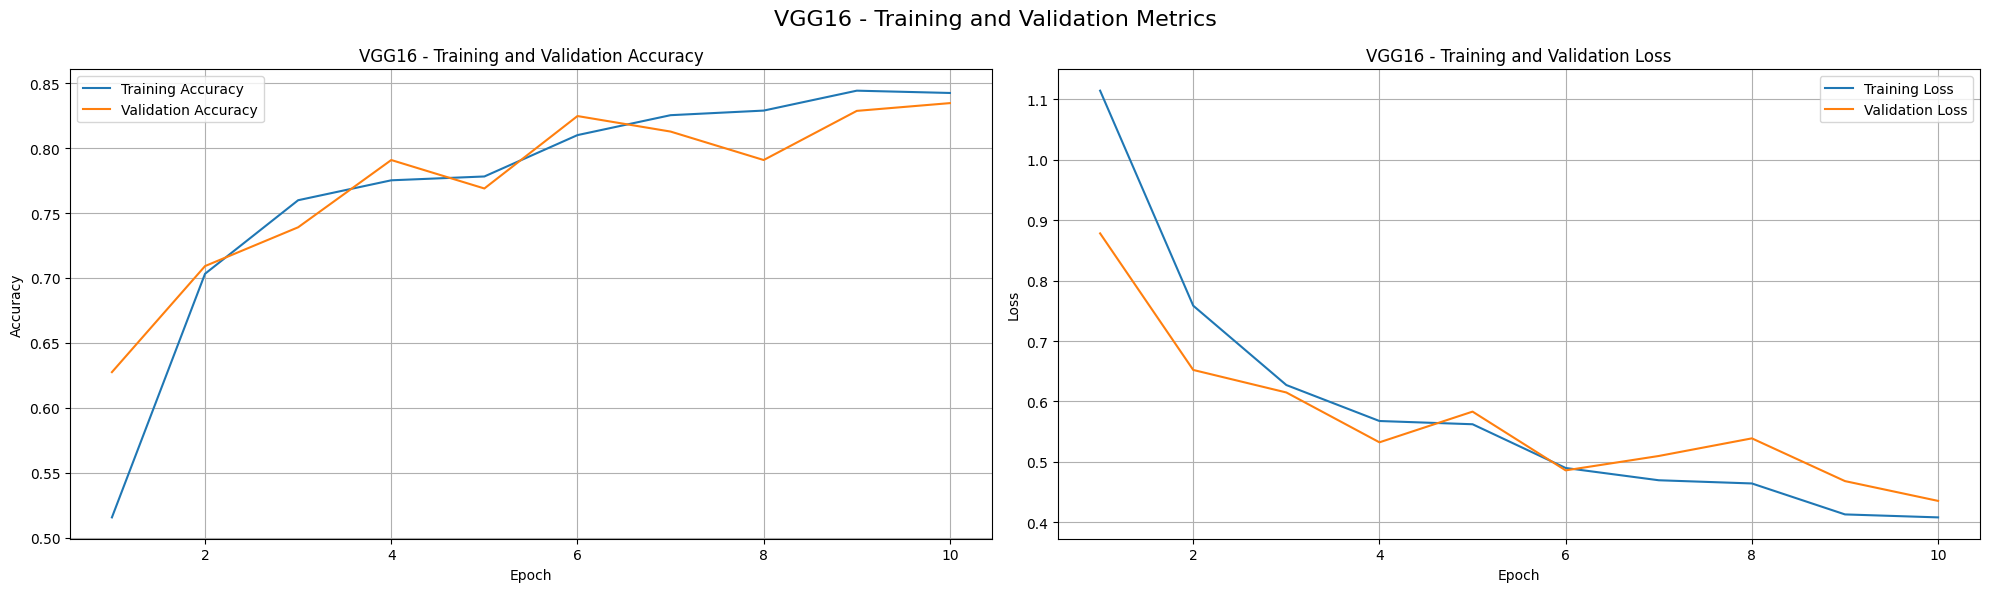

In [18]:
## Plotting the metrics ##

acc = VGG16_history.history['accuracy']
val_acc = VGG16_history.history['val_accuracy']
loss = VGG16_history.history['loss']
val_loss = VGG16_history.history['val_loss']
epochs_range = range(1, len(VGG16_history.history['accuracy']) + 1)

## Creating the subplots ##
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('VGG16 - Training and Validation Metrics', fontsize=16)

## Plotting Accuracy ##
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('VGG16 - Training and Validation Accuracy')
ax1.legend()
ax1.grid(True)

## Plotting Loss ##
ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('VGG16 - Training and Validation Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [20]:
## Evaluating the model on test data ##
test_loss, test_accuracy, test_precision, test_recall = VGG16_model.evaluate(test_generator)
print(f'\nVGG16 Test accuracy: {test_accuracy:.4f}')
print(f'VGG16 Test precision: {test_precision:.4f}')
print(f'VGG16 Test recall: {test_recall:.4f}')
print(f'VGG16 Test loss: {test_loss:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 122s 17s/step - accuracy: 0.7770 - loss: 0.5702 - precision: 0.7981 - recall: 0.7526

VGG16 Test accuracy: 0.8252
VGG16 Test precision: 0.8426
VGG16 Test recall: 0.8049
VGG16 Test loss: 0.4656


In [21]:
model_comparison.append({
    'Model': 'VGG16',
    'Test Accuracy': 0.8252,
    'Test Precision': 0.8426,
    'Test Recall': 0.8049})

In [21]:
## Generating the predictions ##
batch_size = 32
test_generator.reset()
predictions = VGG16_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step


VGG16 - Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      0.78      0.86        80
  meningioma       0.70      0.76      0.73        63
    no_tumor       0.87      0.82      0.84        49
   pituitary       0.79      0.98      0.88        54

    accuracy                           0.83       246
   macro avg       0.83      0.83      0.83       246
weighted avg       0.84      0.83      0.83       246



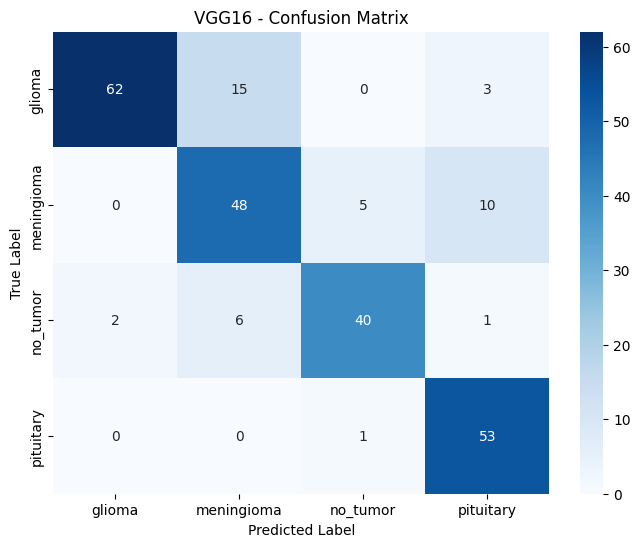

In [22]:
## Getting the class names in the correct order as defined by the generator ##
class_names = list(test_generator.class_indices.keys())

## Generating the classification report ##
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("VGG16 - Classification Report:\n", report)

## Generating and plotting the confusion matrix ##
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('VGG16 - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **3. DenseNet121**

In [ ]:
## Loading the pre-trained VGG16 base model ##
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #Removing the fully connected top layer and replacing with custom layer
base_model.trainable = False #Freezing the layers of base model

## Building the custom layers ##
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x) # Dropout for regularization to prevent overfitting
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(4, activation='softmax')(x) # Output layer with softmax for 4 classes

## Combining the base model with your custom classification layers ##
DenseNet_model = models.Model(inputs=base_model.input, outputs=predictions)
DenseNet_model.compile(optimizer=Adam(learning_rate=0.0001), # Starting with a small learning rate for fine-tuning
              loss='categorical_crossentropy',metrics=['accuracy',
                                                       tf.keras.metrics.Precision(name='precision'),
                                                       tf.keras.metrics.Recall(name='recall')])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
DenseNet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,333,316 (27.97 MB)

 Trainable params: 295,812 (1.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
DenseNet_history = DenseNet_model.fit(
        train_generator,
        validation_data=validate_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 450s 8s/step - accuracy: 0.3578 - loss: 1.3820 - precision: 0.4801 - recall: 0.1643 - val_accuracy: 0.6693 - val_loss: 0.9352 - val_precision: 0.9349 - val_recall: 0.3147
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 421s 8s/step - accuracy: 0.5697 - loss: 1.0239 - precision: 0.7560 - recall: 0.3506 - val_accuracy: 0.7410 - val_loss: 0.7339 - val_precision: 0.8523 - val_recall: 0.5518
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 457s 9s/step - accuracy: 0.6655 - loss: 0.8192 - precision: 0.8005 - recall: 0.5164 - val_accuracy: 0.7789 - val_loss: 0.6119 - val_precision: 0.8454 - val_recall: 0.6534
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 491s 8s/step - accuracy: 0.7505 - loss: 0.6763 - precision: 0.8452 - recall: 0.6319 - val_accuracy: 0.8048 - val_loss: 0.5636 - val_precision: 0.8357 - val_recall: 0.7092
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 423s 8s/step - accuracy: 0.7667 - loss: 0.6225 - precision: 0.8467 - recall: 0.6788 - val_accuracy: 0.8287 - val_loss: 0.5241 

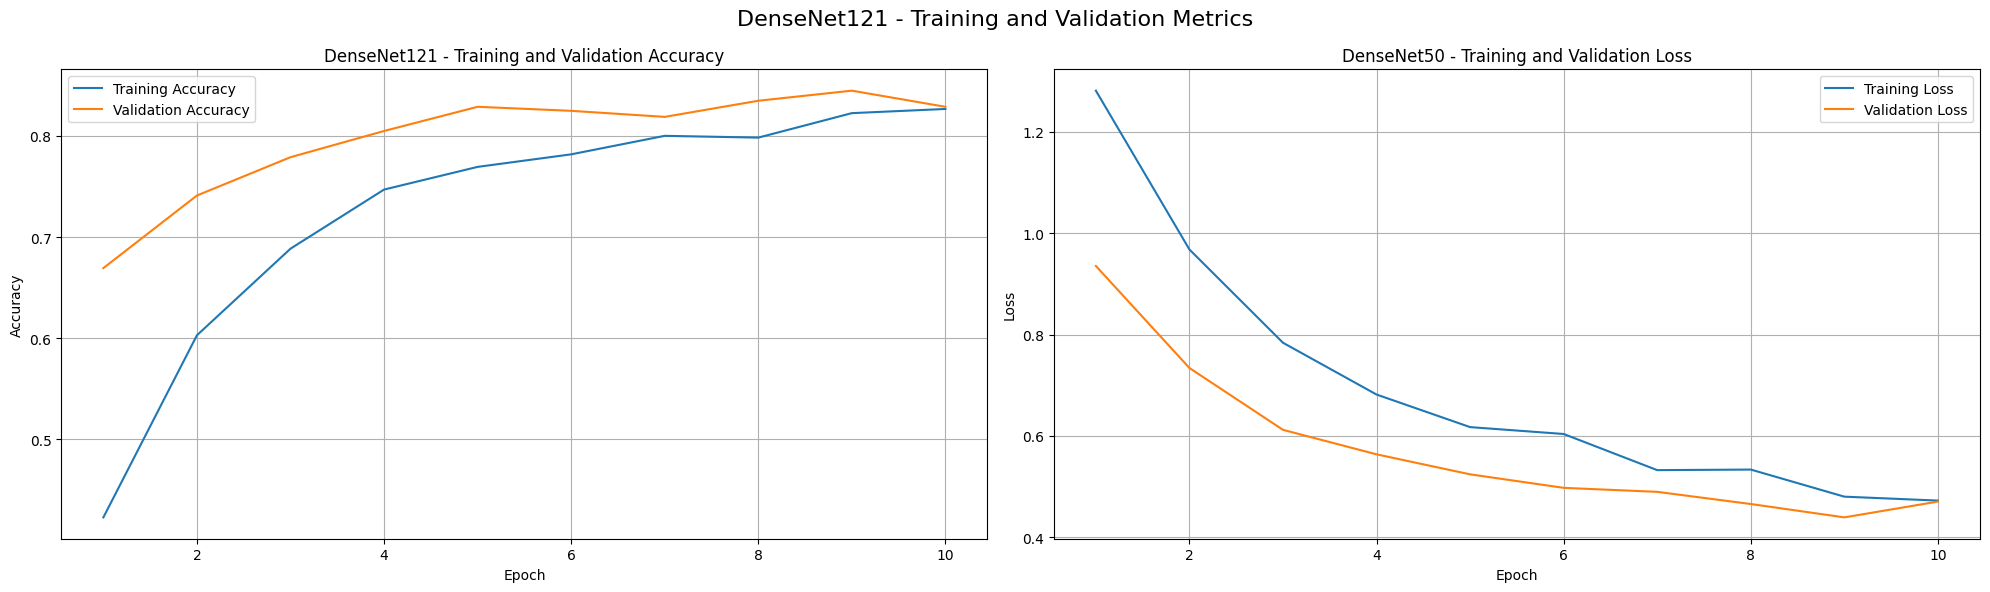

In [ ]:
## Plotting the metrics ##

acc = DenseNet_history.history['accuracy']
val_acc = DenseNet_history.history['val_accuracy']
loss = DenseNet_history.history['loss']
val_loss = DenseNet_history.history['val_loss']
epochs_range = range(1, len(DenseNet_history.history['accuracy']) + 1)

## Creating the subplots ##
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('DenseNet121 - Training and Validation Metrics', fontsize=16)

## Plotting Accuracy ##
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('DenseNet121 - Training and Validation Accuracy')
ax1.legend()
ax1.grid(True)

## Plotting Loss ##
ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('DenseNet121 - Training and Validation Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
## Evaluating the model on test data ##
test_loss, test_accuracy, test_precision, test_recall = DenseNet_model.evaluate(test_generator)
print(f'\nDenseNet Test accuracy: {test_accuracy:.4f}')
print(f'DenseNet Test precision: {test_precision:.4f}')
print(f'DenseNet Test recall: {test_recall:.4f}')
print(f'DenseNet Test loss: {test_loss:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 15s/step - accuracy: 0.7617 - loss: 0.5390 - precision: 0.8352 - recall: 0.7290

DenseNet Test accuracy: 0.7724
DenseNet Test precision: 0.8235
DenseNet Test recall: 0.7398
DenseNet Test loss: 0.5467


In [22]:
model_comparison.append({
    'Model': 'DenseNet121',
    'Test Accuracy': 0.7724,
    'Test Precision': 0.8235,
    'Test Recall': 0.7398})

In [ ]:
## Generating the predictions ##
batch_size = 32
test_generator.reset()
predictions = DenseNet_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 65s 8s/step


DenseNet121 - Classification Report:
               precision    recall  f1-score   support

      glioma       0.90      0.86      0.88        80
  meningioma       0.71      0.48      0.57        63
    no_tumor       0.88      0.78      0.83        49
   pituitary       0.63      0.98      0.77        54

    accuracy                           0.77       246
   macro avg       0.78      0.77      0.76       246
weighted avg       0.79      0.77      0.77       246



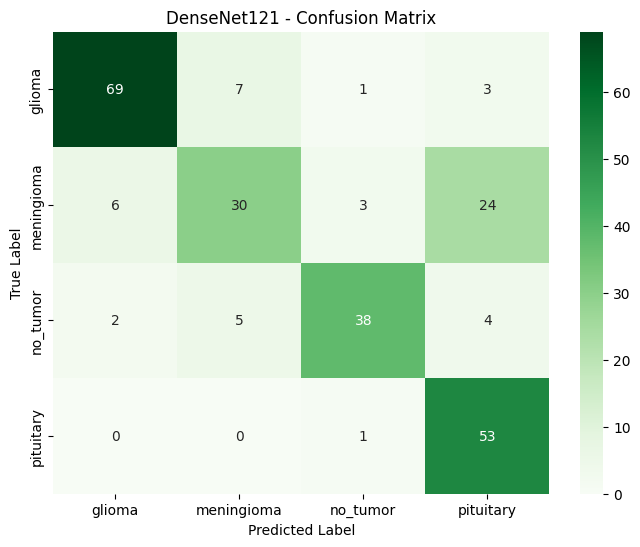

In [ ]:
## Getting the class names in the correct order as defined by the generator ##
class_names = list(test_generator.class_indices.keys())

## Generating the classification report ##
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("DenseNet121 - Classification Report:\n", report)

## Generating and plotting the confusion matrix ##
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('DenseNet121 - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **4. MobileNet**

In [ ]:
## Loading the pre-trained VGG16 base model ##
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #Removing the fully connected top layer and replacing with custom layer
base_model.trainable = False #Freezing the layers of base model

## Building the custom layers ##
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x) # Dropout for regularization to prevent overfitting
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(4, activation='softmax')(x) # Output layer with softmax for 4 classes

## Combining the base model with your custom classification layers ##
MobileNet_model = models.Model(inputs=base_model.input, outputs=predictions)
MobileNet_model.compile(optimizer=Adam(learning_rate=0.001), # Starting with a small learning rate for fine-tuning
              loss='categorical_crossentropy',metrics=['accuracy',
                                                       tf.keras.metrics.Precision(name='precision'),
                                                       tf.keras.metrics.Recall(name='recall')])

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
MobileNet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,524,676 (13.45 MB)

 Trainable params: 295,812 (1.13 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
MobileNet_history = MobileNet_model.fit(
        train_generator,
        validation_data=validate_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.5734 - loss: 1.0277 - precision: 0.6604 - recall: 0.4512 - val_accuracy: 0.8307 - val_loss: 0.4104 - val_precision: 0.8691 - val_recall: 0.8068
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.8559 - loss: 0.3881 - precision: 0.8725 - recall: 0.8314 - val_accuracy: 0.8526 - val_loss: 0.3829 - val_precision: 0.8771 - val_recall: 0.8386
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.8972 - loss: 0.3001 - precision: 0.9114 - recall: 0.8745 - val_accuracy: 0.8865 - val_loss: 0.3434 - val_precision: 0.8918 - val_recall: 0.8865
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8819 - loss: 0.3004 - precision: 0.8971 - recall: 0.8679 - val_accuracy: 0.8865 - val_loss: 0.3429 - val_precision: 0.8952 - val_recall: 0.8845
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.8911 - loss: 0.2691 - precision: 0.9059 - recall: 0.8813 - val_accuracy: 0.8665 - val_loss: 0.3402 

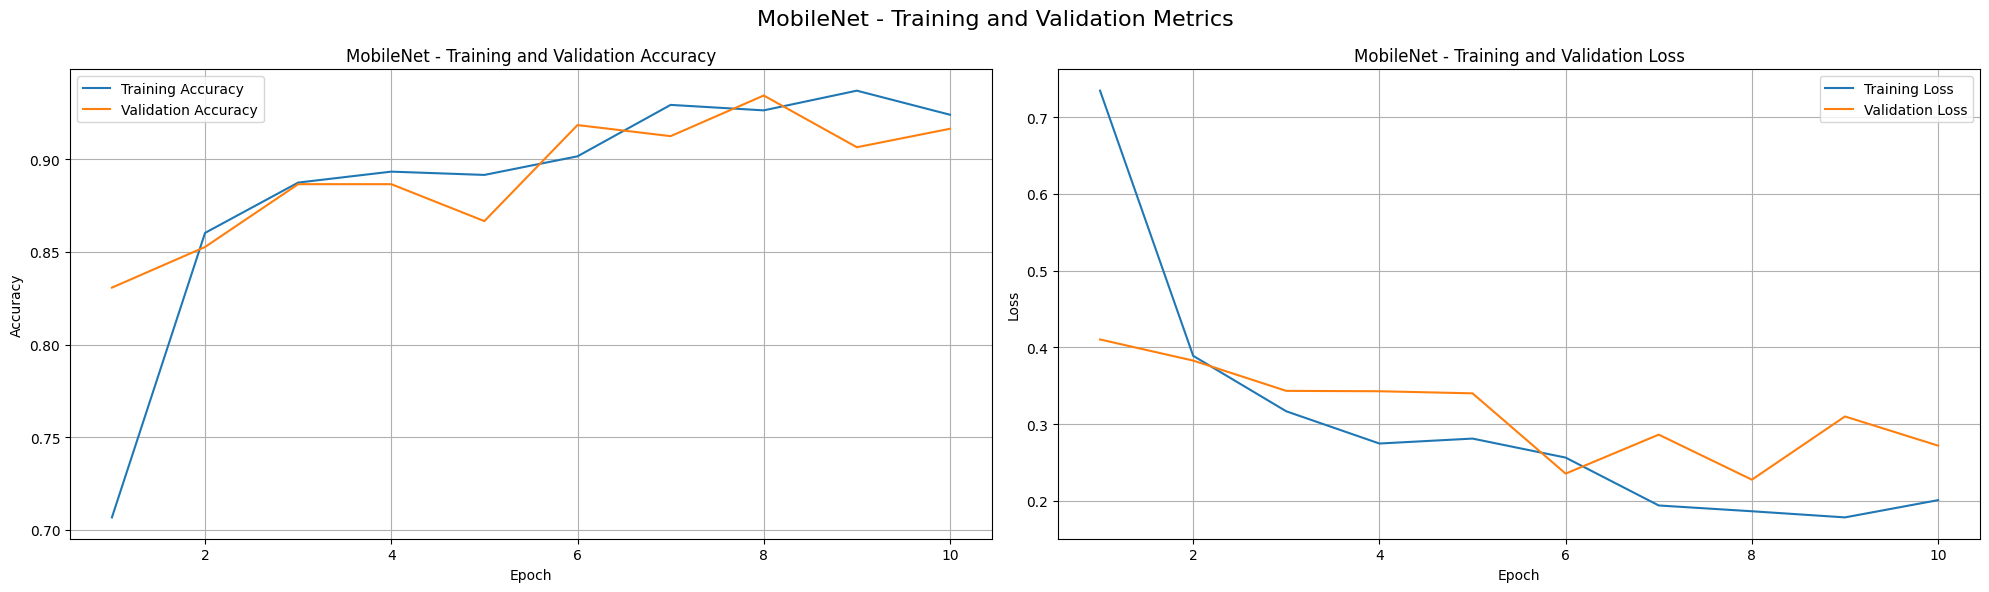

In [ ]:
## Plotting the metrics ##

acc = MobileNet_history.history['accuracy']
val_acc = MobileNet_history.history['val_accuracy']
loss = MobileNet_history.history['loss']
val_loss = MobileNet_history.history['val_loss']
epochs_range = range(1, len(MobileNet_history.history['accuracy']) + 1)

## Creating the subplots ##
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('MobileNet - Training and Validation Metrics', fontsize=16)

## Plotting Accuracy ##
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('MobileNet - Training and Validation Accuracy')
ax1.legend()
ax1.grid(True)

## Plotting Loss ##
ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('MobileNet - Training and Validation Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
## Evaluating the model on test data ##
test_loss, test_accuracy, test_precision, test_recall = MobileNet_model.evaluate(test_generator)
print(f'\nMobileNet Test accuracy: {test_accuracy:.4f}')
print(f'MobileNet Test precision: {test_precision:.4f}')
print(f'MobileNet Test recall: {test_recall:.4f}')
print(f'MobileNet Test loss: {test_loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8907 - loss: 0.2629 - precision: 0.9120 - recall: 0.8907

MobileNet Test accuracy: 0.9065
MobileNet Test precision: 0.9177
MobileNet Test recall: 0.9065
MobileNet Test loss: 0.2632


In [23]:
model_comparison.append({
    'Model': 'MobileNet',
    'Test Accuracy': 0.9065,
    'Test Precision': 0.9177,
    'Test Recall': 0.9065})

In [ ]:
## Generating the predictions ##
batch_size = 32
test_generator.reset()
predictions = MobileNet_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


MobileNet - Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      0.93      0.95        80
  meningioma       0.89      0.79      0.84        63
    no_tumor       0.94      0.92      0.93        49
   pituitary       0.82      1.00      0.90        54

    accuracy                           0.91       246
   macro avg       0.91      0.91      0.90       246
weighted avg       0.91      0.91      0.91       246



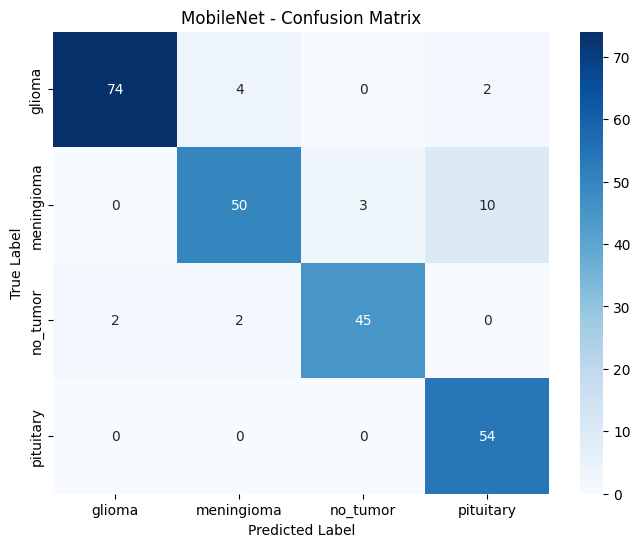

In [ ]:
## Getting the class names in the correct order as defined by the generator ##
class_names = list(test_generator.class_indices.keys())

## Generating the classification report ##
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("MobileNet - Classification Report:\n", report)

## Generating and plotting the confusion matrix ##
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('MobileNet - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **5. InceptionV3**

In [42]:
## InceptionV3 requires an input size of 299,299 ##
inception_train_gen = train_datagen.flow_from_directory(train_data_path, target_size=(299, 299), batch_size=32)
inception_val_gen = val_datagen.flow_from_directory(validate_data_path, target_size=(299, 299), batch_size=32)
inception_test_gen = test_datagen.flow_from_directory(
                     test_data_path,
                     target_size=(299, 299),
                     batch_size=32,
                     class_mode='categorical',
                     shuffle=False)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [24]:
## Loading the pre-trained InceptionV3 base model ##
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3)) #Removing the fully connected top layer and replacing with custom layer
base_model.trainable = False #Freezing the layers of base model

## Building the custom layers ##
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x) # Dropout for regularization to prevent overfitting
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(4, activation='softmax')(x) # Output layer with softmax for 4 classes

## Combining the base model with your custom classification layers ##
Inception_model = models.Model(inputs=base_model.input, outputs=predictions)
Inception_model.compile(optimizer=Adam(learning_rate=0.001), # Starting with a small learning rate for fine-tuning
              loss='categorical_crossentropy',metrics=['accuracy',
                                                       tf.keras.metrics.Precision(name='precision'),
                                                       tf.keras.metrics.Recall(name='recall')])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [25]:
Inception_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,360,740 (85.30 MB)

 Trainable params: 557,956 (2.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [28]:
Inception_history = Inception_model.fit(
                    inception_train_gen,
                    validation_data=inception_val_gen,
                    epochs=10,
                    callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 49s 930ms/step - accuracy: 0.8709 - loss: 0.3289 - precision: 0.8835 - recall: 0.8628 - val_accuracy: 0.8944 - val_loss: 0.3073 - val_precision: 0.9093 - val_recall: 0.8785
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 889ms/step - accuracy: 0.8988 - loss: 0.2417 - precision: 0.9142 - recall: 0.8908 - val_accuracy: 0.8944 - val_loss: 0.3031 - val_precision: 0.9104 - val_recall: 0.8904
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 49s 918ms/step - accuracy: 0.9023 - loss: 0.2693 - precision: 0.9135 - recall: 0.8938 - val_accuracy: 0.8984 - val_loss: 0.3066 - val_precision: 0.9067 - val_recall: 0.8904
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 912ms/step - accuracy: 0.9129 - loss: 0.2285 - precision: 0.9216 - recall: 0.9037 - val_accuracy: 0.8924 - val_loss: 0.3097 - val_precision: 0.8972 - val_recall: 0.8865
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 905ms/step - accuracy: 0.9144 - loss: 0.2486 - precision: 0.9201 - recall: 0.9037 - val_accuracy: 0.9024 - val_los

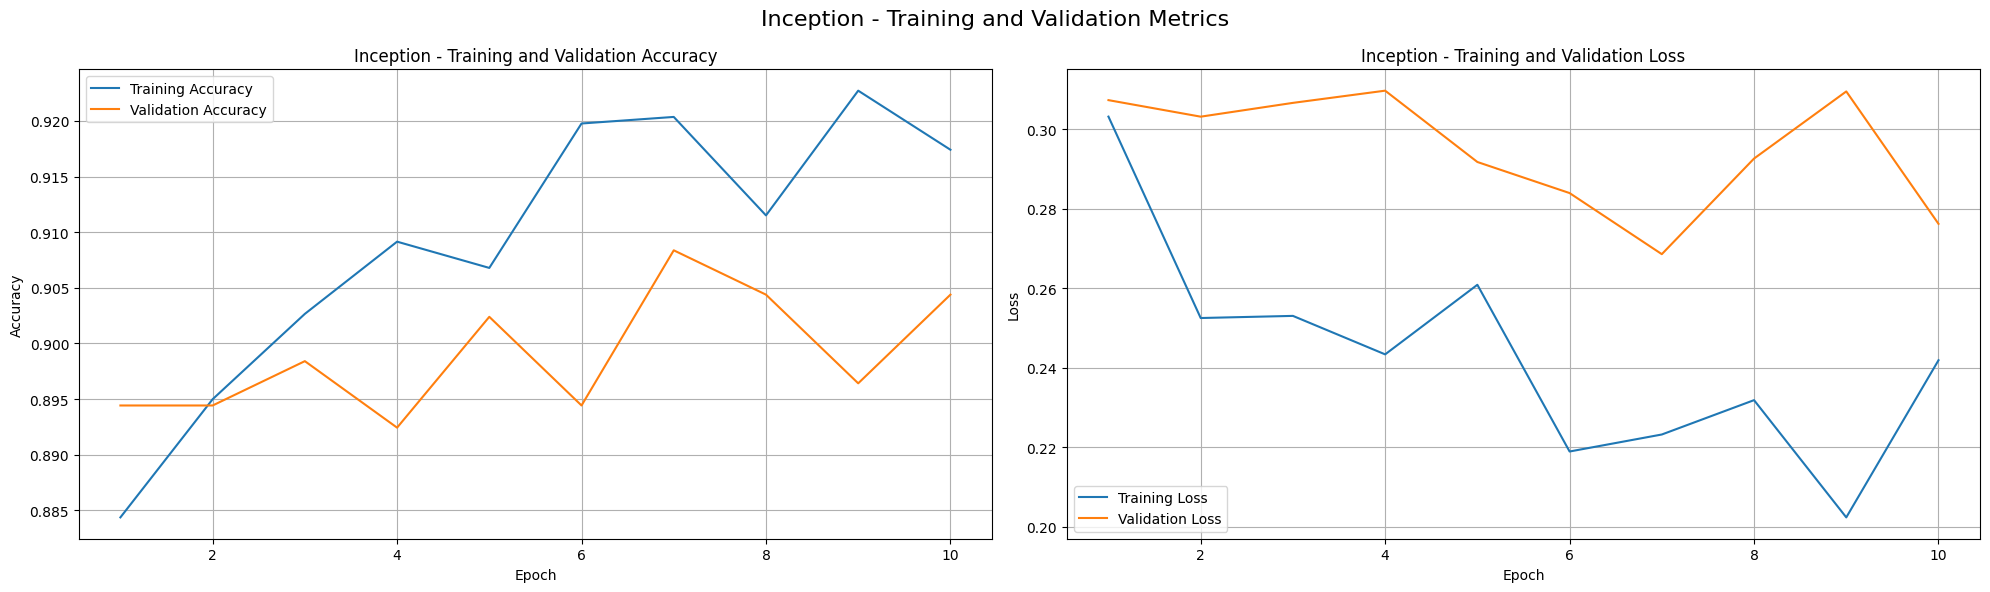

In [30]:
## Plotting the metrics ##

acc = Inception_history.history['accuracy']
val_acc = Inception_history.history['val_accuracy']
loss = Inception_history.history['loss']
val_loss = Inception_history.history['val_loss']
epochs_range = range(1, len(Inception_history.history['accuracy']) + 1)

## Creating the subplots ##
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Inception - Training and Validation Metrics', fontsize=16)

## Plotting Accuracy ##
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Inception - Training and Validation Accuracy')
ax1.legend()
ax1.grid(True)

## Plotting Loss ##
ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Inception - Training and Validation Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [43]:
## Evaluating the model on test data ##
test_loss, test_accuracy, test_precision, test_recall = Inception_model.evaluate(inception_test_gen)
print(f'\nInception Test accuracy: {test_accuracy:.4f}')
print(f'Inception Test precision: {test_precision:.4f}')
print(f'Inception Test recall: {test_recall:.4f}')
print(f'Inception Test loss: {test_loss:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.8752 - loss: 0.3800 - precision: 0.8836 - recall: 0.8717

Inception Test accuracy: 0.8740
Inception Test precision: 0.8770
Inception Test recall: 0.8699
Inception Test loss: 0.4031


In [24]:
model_comparison.append({
    'Model': 'InceptionV3',
    'Test Accuracy': 0.8740,
    'Test Precision': 0.8770,
    'Test Recall': 0.8699})

In [44]:
## Generating the predictions ##
batch_size = 32
inception_test_gen.reset()
predictions = Inception_model.predict(inception_test_gen, steps=inception_test_gen.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = inception_test_gen.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step


['glioma', 'meningioma', 'no_tumor', 'pituitary']
InceptionV3 - Classification Report:
               precision    recall  f1-score   support

      glioma       0.93      0.95      0.94        80
  meningioma       0.83      0.68      0.75        63
    no_tumor       0.90      0.88      0.89        49
   pituitary       0.83      0.98      0.90        54

    accuracy                           0.87       246
   macro avg       0.87      0.87      0.87       246
weighted avg       0.87      0.87      0.87       246



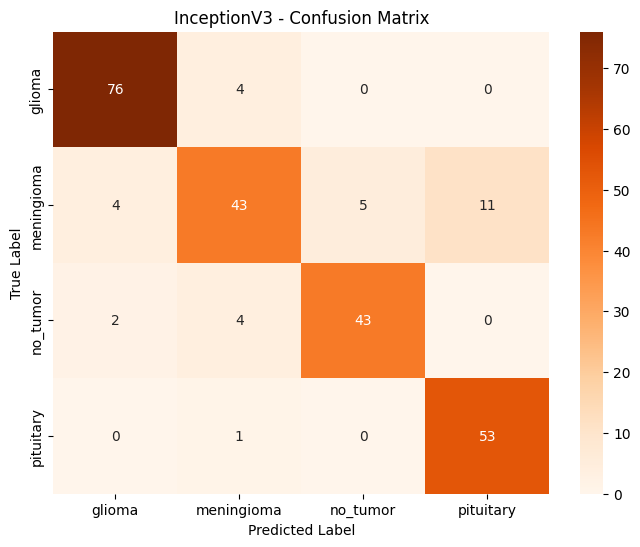

In [45]:
## Getting the class names in the correct order as defined by the generator ##
class_names = list(inception_test_gen.class_indices.keys())
print(class_names)

## Generating the classification report ##
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("InceptionV3 - Classification Report:\n", report)

## Generating and plotting the confusion matrix ##
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.title('InceptionV3 - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Comparing the Models**

In [26]:
ModelComparison_df = pd.DataFrame(model_comparison)
ModelComparison_df

,Model,Test Accuracy,Test Precision,Test Recall
0,CustomCNN,0.7276,0.7789,0.6301
1,ResNet50,0.5325,0.7059,0.2439
2,VGG16,0.8252,0.8426,0.8049
3,DenseNet121,0.7724,0.8235,0.7398
4,MobileNet,0.9065,0.9177,0.9065
5,InceptionV3,0.8740,0.8770,0.8699


In [28]:
## Sorted df ##
ModelComparison_df = ModelComparison_df.sort_values(by='Test Accuracy', ascending=False)
ModelComparison_df

,Model,Test Accuracy,Test Precision,Test Recall
4,MobileNet,0.9065,0.9177,0.9065
5,InceptionV3,0.8740,0.8770,0.8699
2,VGG16,0.8252,0.8426,0.8049
3,DenseNet121,0.7724,0.8235,0.7398
0,CustomCNN,0.7276,0.7789,0.6301
1,ResNet50,0.5325,0.7059,0.2439


In [27]:
ModelComparison_df.to_csv('/content/drive/MyDrive/ModelComparison.csv', index=False)

In [4]:
Models_df = pd.read_csv('/content/drive/MyDrive/ModelComparison.csv')

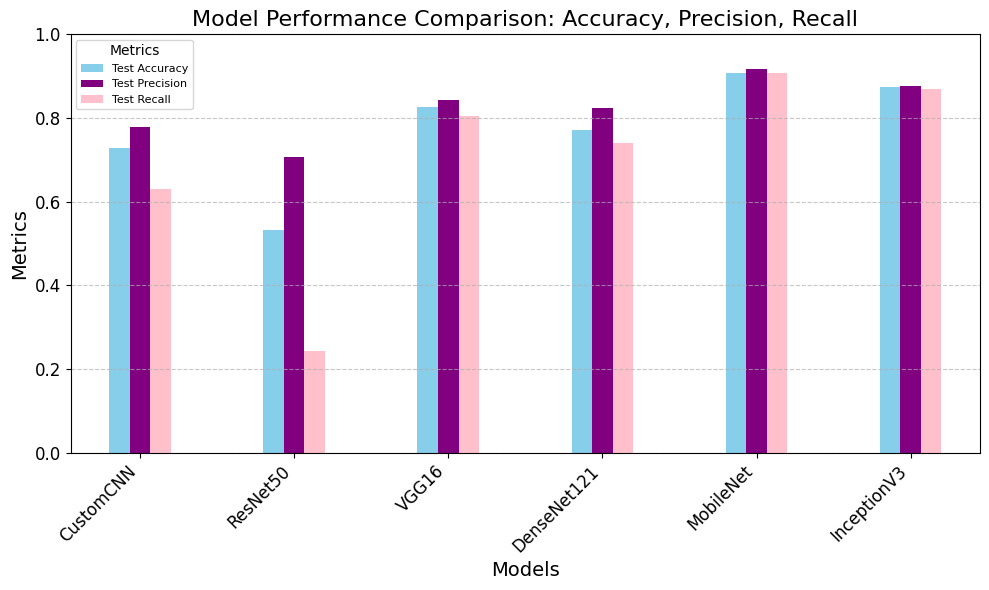

In [30]:
## Setting Model as the index for easier plotting ##
model_comparison_indexed = Models_df.set_index('Model')

plt.figure(figsize=(10,6))
model_comparison_indexed[['Test Accuracy', 'Test Precision', 'Test Recall']].plot(
    kind='bar',
    ax=plt.gca(),
    width=0.4,
    color=['skyblue', 'purple', 'pink']
)

plt.title('Model Performance Comparison: Accuracy, Precision, Recall', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1) # Metrics are between 0 and 1
plt.legend(title='Metrics', fontsize=8, title_fontsize='10')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **Saving the best Model**

In [ ]:
MobileNet_model.save('/content/drive/MyDrive/MobileNetModel.h5')